# Modelo de texto para predicción de viabilidad de startups

En este notebook se entrena un modelo **solo con la columna de texto `descripcion`** para predecir la viabilidad de una startup. El objetivo es complementar al modelo tabular y, sobre todo, **aprovechar mejor los montos numéricos y las señales financieras** que aparecen en las descripciones (por ejemplo: `25k USD`, `350k`, `200 clientes`, `12%`, etc.).

## 1. Importación de librerías y configuración básica

Primero se importan las librerías necesarias y se detecta la raíz del proyecto para no romper rutas al ejecutar el notebook desde distintas carpetas.

In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from joblib import dump

RANDOM_STATE = 42

# Detectar raíz del proyecto (para correr desde /notebooks sin romper rutas)
PROJECT_ROOT = next(
    p for p in [Path.cwd(), *Path.cwd().parents]
    if (p / "src").exists() and (p / "data").exists()
)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Proyecto raíz:", PROJECT_ROOT)

Proyecto raíz: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning


## 2. Carga del dataset procesado

Se utiliza el archivo procesado `startups_sintetico_1000_processed.csv`, que ya contiene la columna de texto `descripcion` y la etiqueta binaria `viabilidad`.

In [2]:
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_1000_processed.csv"

df = pd.read_csv(DATA_PROCESSED, encoding="utf-8")
assert {"descripcion", "viabilidad"}.issubset(df.columns), "Faltan columnas 'descripcion' y/o 'viabilidad'."

X_text = df["descripcion"].astype(str)
y = df["viabilidad"].astype(int)

print("Shape total:", df.shape)
print("\nDistribución de la variable objetivo (viabilidad):")
display(y.value_counts(normalize=True))

Shape total: (1000, 51)

Distribución de la variable objetivo (viabilidad):


viabilidad
1    0.573
0    0.427
Name: proportion, dtype: float64

## 3. División en entrenamiento y prueba

Se divide el conjunto en 80% entrenamiento y 20% prueba, manteniendo la proporción de clases mediante `stratify`.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (800,) Test: (200,)


## 4. Transformación de texto: TF‑IDF + señales numéricas

El modelo de texto se basa en **TF‑IDF + Regresión Logística**, pero antes de vectorizar se enriquece la descripción con algunas etiquetas artificiales que resumen los montos y señales financieras detectadas. 

Ejemplos de estas etiquetas:
- `__monto_medio__`, `__monto_alto__`, `__monto_muy_alto__`
- `__clientes_medios__`, `__clientes_altos__`, `__muchos_clientes__`
- `__crecimiento_medio__`, `__crecimiento_alto__`, `__crecimiento_explosivo__`

De esta forma, el vectorizador TF‑IDF puede aprender pesos específicos para estas señales.

In [5]:
import re

# Stopwords básicas en español (se puede ajustar según necesidad)
STOP_ES = {
    "a","ante","bajo","con","contra","de","desde","durante","en","entre","hacia",
    "hasta","para","por","según","sin","sobre","tras","el","la","los","las","un",
    "una","unos","unas","lo","al","del","y","o","u","e","que","se","su","sus",
    "es","son","ser","fue","han","ha","como","más","menos","muy","ya","no","sí",
    "si","pero","también","porque","cuando","este","esta","estos","estas"
}


def _augment_text_with_numeric_signals(text: str) -> str:
    """Enriquece la descripción con tags sobre montos, clientes, porcentajes
    y algunas señales textuales de riesgo.

    No se elimina nada del texto original; solo se agregan tokens especiales
    como '__monto_alto__' o '__sin_clientes__' que TF-IDF podrá usar.
    """
    if not isinstance(text, str):
        text = str(text)
    raw = text.lower()
    tags = []

    # -------------------- MONTOS --------------------
    money_pattern = re.compile(
        r"(\d+[.,]?\d*)\s*(k|mil|m|mm|millones)?\s*(usd|us\$|\$)?",
        flags=re.IGNORECASE,
    )
    money_vals = []
    for m in money_pattern.finditer(raw):
        num_str, mult_str, _ = m.groups()
        clean = num_str.replace(".", "").replace(",", "")
        try:
            base = float(clean)
        except ValueError:
            continue
        factor = 1.0
        if mult_str:
            ms = mult_str.lower()
            if ms in {"k", "mil"}:
                factor = 1e3
            elif ms in {"m", "mm", "millones"}:
                factor = 1e6
        money = base * factor
        if money > 0:
            money_vals.append(money)

    if money_vals:
        max_money = max(money_vals)
        if max_money >= 500_000:
            tags.append("__monto_muy_alto__")
        elif max_money >= 200_000:
            tags.append("__monto_alto__")
        elif max_money >= 50_000:
            tags.append("__monto_medio__")
        else:
            tags.append("__monto_pequeno__")

    # -------------------- CLIENTES / USUARIOS --------------------
    clients_pattern = re.compile(
        r"(\d+[.,]?\d*)\s+(clientes?|usuarios?|empresas|negocios|tiendas|descargas|suscriptores)",
        flags=re.IGNORECASE,
    )
    client_vals = []
    for m in clients_pattern.finditer(raw):
        num_str, _ = m.groups()
        clean = num_str.replace(".", "").replace(",", "")
        try:
            n = float(clean)
        except ValueError:
            continue
        if n > 0:
            client_vals.append(n)

    if client_vals:
        max_clients = max(client_vals)
        if max_clients >= 5_000:
            tags.append("__muchos_clientes__")
        elif max_clients >= 1_000:
            tags.append("__clientes_altos__")
        elif max_clients >= 200:
            tags.append("__clientes_medios__")
        else:
            tags.append("__clientes_bajos__")

    # -------------------- PORCENTAJES --------------------
    pct_pattern = re.compile(r"(\d+[.,]?\d*)\s*%", flags=re.IGNORECASE)
    pct_vals = []
    for m in pct_pattern.finditer(raw):
        num_str = m.group(1)
        clean = num_str.replace(",", ".")
        try:
            p = float(clean)
        except ValueError:
            continue
        if p > 0:
            pct_vals.append(p)

    if pct_vals:
        max_pct = max(pct_vals)
        if max_pct >= 100:
            tags.append("__crecimiento_explosivo__")
        elif max_pct >= 50:
            tags.append("__crecimiento_alto__")
        elif max_pct >= 20:
            tags.append("__crecimiento_medio__")
        else:
            tags.append("__crecimiento_bajo__")

    # -------------------- SEÑALES TEXTUALES DE RIESGO --------------------
    if "sin clientes" in raw or "sin usuarios" in raw:
        tags.append("__sin_clientes__")
    if "sin ventas" in raw or "sin ingresos" in raw:
        tags.append("__sin_ingresos__")
    if "solo una idea" in raw or "fase conceptual" in raw or "fase idea" in raw:
        tags.append("__fase_idea__")
    if "prototipo" in raw and "sin pilotos" in raw:
        tags.append("__prototipo_sin_validar__")
    if "deuda" in raw or "deudas" in raw or "pérdidas" in raw or "perdidas" in raw:
        tags.append("__problemas_financieros__")
    if "cerrado" in raw or "cerrada" in raw:
        tags.append("__estado_cerrado__")

    # -------------------- MRR --------------------
    if "mrr" in raw or "ingresos recurrentes" in raw:
        tags.append("__tiene_mrr__")

    if not tags:
        return text

    extra = " " + " ".join(sorted(set(tags)))
    return text + extra


pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1500,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.95,
        stop_words=list(STOP_ES),
        token_pattern=r"(?u)\b[\wáéíóúñ%$]{2,}\b",
        sublinear_tf=True,
        strip_accents="unicode",
        preprocessor=_augment_text_with_numeric_signals,
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    ))
])

pipe.fit(X_train, y_train)
print("✅ Modelo de texto entrenado.")

✅ Modelo de texto entrenado.


## 5. Evaluación inicial en el conjunto de prueba

Se evalúa el modelo con el umbral estándar de 0.5 para tener una primera idea de su desempeño.

In [6]:
proba = pipe.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
f1_05 = f1_score(y_test, pred05)

print("ROC-AUC:", round(auc, 3))
print("F1@0.5:", round(f1_05, 3))
print("\nClassification report:")
print(classification_report(y_test, pred05, zero_division=0))

print("\nMatriz de confusión @0.5:")
print(confusion_matrix(y_test, pred05))

ROC-AUC: 0.494
F1@0.5: 0.564

Classification report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43        85
           1       0.57      0.56      0.56       115

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.51      0.51      0.51       200


Matriz de confusión @0.5:
[[37 48]
 [51 64]]


## 6. Curvas ROC y Precision‑Recall

Las siguientes gráficas permiten visualizar el comportamiento del modelo en términos de tasa de verdaderos positivos y relación precisión‑recobrado.

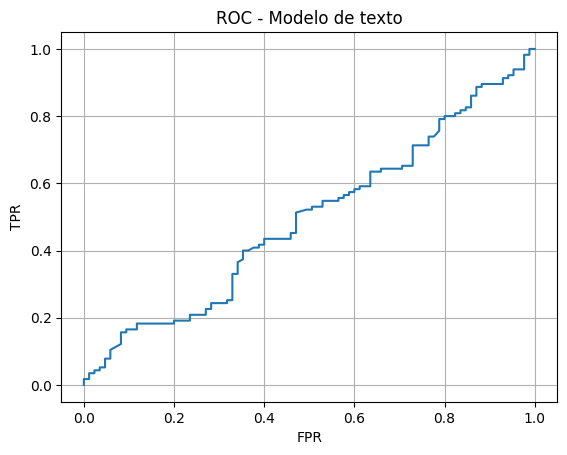

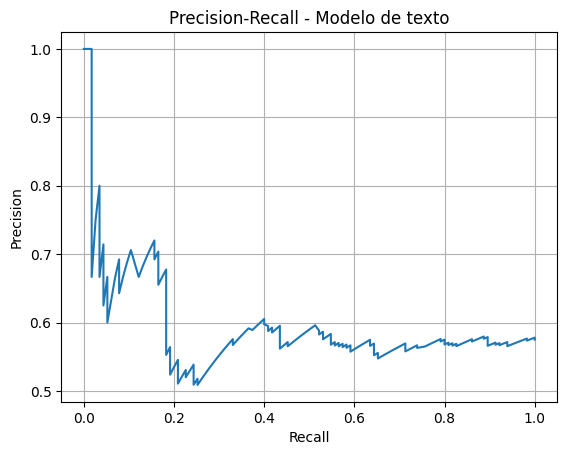

In [7]:
fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, _ = precision_recall_curve(y_test, proba)

plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC - Modelo de texto")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.title("Precision-Recall - Modelo de texto")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

## 7. Búsqueda de umbral óptimo por F1

Como la viabilidad es una clasificación binaria, se prueba una rejilla de umbrales y se elige aquel que maximiza el F1‑score en el conjunto de prueba.

Mejor umbral por F1: 0.1 | F1: 0.73


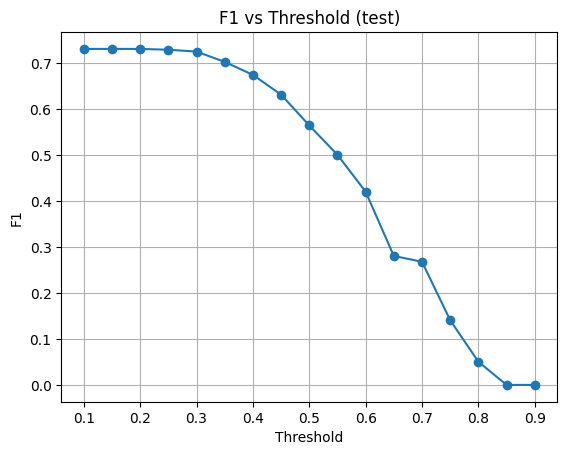

In [8]:
ths = np.linspace(0.1, 0.9, 17)
f1s = []

for t in ths:
    pred_t = (proba >= t).astype(int)
    f1s.append(f1_score(y_test, pred_t))

best_t = ths[int(np.argmax(f1s))]
best_f1 = float(np.max(f1s))

print("Mejor umbral por F1:", round(best_t, 3), "| F1:", round(best_f1, 3))

plt.figure()
plt.plot(ths, f1s, marker="o")
plt.title("F1 vs Threshold (test)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.show()

## 7.1. Umbral de demostración con mayor precisión

Además del umbral que maximiza el F1-score, se calcula un umbral más estricto pensado para demostraciones, buscando una precisión mínima (por ejemplo 0.7) para reducir falsos positivos.

In [9]:
from sklearn.metrics import precision_recall_curve

prec, rec, ths = precision_recall_curve(y_test, proba)

target_prec = 0.7
mask = prec[:-1] >= target_prec  # 'ths' tiene longitud len(prec) - 1

if not mask.any():
    print("No se encontró threshold con precisión >= ", target_prec, ". Usando 0.5 por defecto.")
    thr_demo = 0.5
else:
    ths_valid = ths[mask]
    rec_valid = rec[:-1][mask]
    thr_demo = float(ths_valid[rec_valid.argmax()])
    print(f"Threshold demo (prec ≥ {target_prec}):", round(thr_demo, 3))

pred_demo = (proba >= thr_demo).astype(int)
print("F1 con thr_demo:", round(f1_score(y_test, pred_demo), 3))

Threshold demo (prec ≥ 0.7): 0.711
F1 con thr_demo: 0.268


## 8. Revisión rápida de vocabulario

Se verifica que algunos tokens clave relacionados con negocio y montos estén realmente presentes en el vocabulario de TF‑IDF.

In [10]:
vec = pipe.named_steps["tfidf"]
tokens_check = ["mrr", "b2b", "usd", "semilla", "25k", "350k", "crecimiento"]
presentes = [t for t in tokens_check if t in vec.vocabulary_]

print("Tokens clave presentes en vocab:", presentes)

Tokens clave presentes en vocab: ['semilla', 'crecimiento']


## 9. Ejemplo de explicación de una predicción

Por último, se prueba el modelo con un ejemplo de descripción y se usa el módulo de explicabilidad para obtener una interpretación en lenguaje natural.

In [14]:
from src.explainability.explicacion import explicar_texto

ejemplo = (
    "Healthtech de telemedicina con 300 médicos registrados, más de 10 000 "
    "consultas realizadas, contratos con 3 clínicas privadas, MRR de 40k USD "
    "y crecimiento mensual del 25%."
)

res = explicar_texto(pipe, ejemplo, thr=thr_demo)

print("Prob:", round(res["probabilidad"], 3), "| Viable:", res["viable"])
print("→ Interpretación:", res["interpretacion"])
print("→ Justificación técnica:", res["justificacion"])

Prob: 0.433 | Viable: False
→ Interpretación: La startup **no parece viable** (probabilidad 0.43) porque no aparecen suficientes señales de tracción o madurez; lo más relevante fue MRR, ingresos recurrentes (MRR) y crecimiento moderado.
→ Justificación técnica: Aportes: MRR:0.070; __tiene_mrr__:0.070; __crecimiento_medio__:0.061; crecimiento:0.049; crecimiento mensual:0.049


## 10. Guardado del modelo de texto

Finalmente se guarda el pipeline entrenado (`TF‑IDF + LR + transformador de montos`) en la carpeta `models/` para reutilizarlo desde otros módulos del proyecto.

In [ ]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dump(pipe, models_dir / "modelo_texto.joblib")
print("Modelo guardado en:", models_dir / "modelo_texto.joblib")

print("✅ Entrenamiento de modelo de texto completado y guardado correctamente.")

Modelo guardado en: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\models\modelo_texto.joblib
✅ Entrenamiento de modelo de texto completado y guardado correctamente.
